# Demonstration of Search

In [1]:
# Import System Packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image
from pathlib import Path
from itertools import islice
import pickle
from scipy.spatial.distance import minkowski, cosine
import sys
sys.path.append("..")

import time
import psutil
print(f"Available RAM: {psutil.virtual_memory().available / 1e9} GB")


Available RAM: 6.1149184 GB


In [2]:
# Import Local Packages
%load_ext autoreload
%autoreload 2  
from modules.extraction.preprocessing import Preprocessing
from modules.extraction.embedding import Embedding 
from modules.retrieval.index.bruteforce import FaissBruteForce
from modules.retrieval.index.lsh import FaissLSH
from modules.retrieval.index.hnsw import FaissHNSW
from modules.retrieval.search import FaissSearch

### Task 4 

Create a notebook named ironclad/notebooks/demo_search.ipynb. 

Precompute the embeddings of ALL images stored in storage/gallery/* and demonstrate nearest neighbor search using the index you've implemented and the four distances measures. 

Report the rank positions of 10 probes. Note your observations in a markdown cell. 

Specifically, consider factors that would impact the performance of the system. Use tables, graphs, and other visualizations to convey your ideas.

> Note: DO NOT print out long outputs. Remember to keep your notebook professional, clean, and organized! Use the notebook format I've provided for the past few assignments. 

In [3]:
# Initialize Params
MODEL_NAME_1 = 'casia-webface'
MODEL_NAME_2 = 'vggface2'
PROBE_IMAGE_DIR = '../storage/probe/'
GALLERY_IMAGE_DIR = '../storage/multi_image_gallery/'
FAISS_INDEX_DIR = '../storage/faiss_index/'

DISTANCE_METRICS = sorted(['euclidean', 'cosine', 'dot_product', 'minkowski'])

In [4]:
# Define Helper Functions

# Function to Compute Distance between two given embeddings
def compute_distance(embedding1, embedding2, distance_metric='euclidean'):
    if distance_metric == 'euclidean':
        return np.linalg.norm(embedding1 - embedding2)
    
    elif distance_metric == 'dot_product':
        return np.dot(embedding1, embedding2)
    
    elif distance_metric == 'cosine':
        return cosine(embedding1, embedding2) 
    
    elif distance_metric == 'minkowski':
        return minkowski(embedding1, embedding2, p=3)
    
# Helper function to generate embedding with give image path
def generate_embedding(model_name, image_path, target_image_size=160):
    # Execute preprocessing
    preprocessing = Preprocessing(image_size=target_image_size, device='mps')
    image = Image.open(image_path)
    image = preprocessing.process(image) # preprocessed image

    # Generate embedding for given image
    model = Embedding(pretrained=model_name, device='mps') # Use Metal (Apple GPU)
    embedding_vector = model.encode(image)

    return embedding_vector

# Helper function to files from given directory
def get_jpg_files(directory, num_files=None):
    directory = Path(directory)
    
    # Get all .jpg files
    jpg_files = directory.rglob("*.jpg")
    
    # If num_files is specified and greater than 0, use islice; otherwise, return all
    return list(islice(jpg_files, num_files)) if num_files else list(jpg_files)


# Helper function to generate embeddings for given image directory
def generate_embeddings(image_dir, num_files=None):
    # Get .jpg files in the probe image directory for given number
    image_paths = get_jpg_files(image_dir, num_files)
    
    # Generate embeddings for probe images
    embeddings = []
    for img_path in image_paths: 
        image_name = str(img_path).split('/')[4]
        personnel = "_".join(image_name.split("_")[:-1])

        embeddings.append({
            "personnel":  personnel,
            "image_name": image_name,
            f"embedding_{MODEL_NAME_1}": generate_embedding(MODEL_NAME_1, img_path),
            f"embedding_{MODEL_NAME_2}": generate_embedding(MODEL_NAME_2, img_path),
            })
        
    embeddings = pd.DataFrame(embeddings)
    return embeddings


# Helper function to load a serialized FAISS index instance from a file.
def load_faiss_index(filepath):
    with open(filepath, 'rb') as f:
        instance = pickle.load(f)
    return instance

In [5]:
# Get 10 probe embeddings
probe_embeddings_10 = generate_embeddings(PROBE_IMAGE_DIR, num_files=10)
print(f"probe_embeddings_10.shape: {probe_embeddings_10.shape}")
display(probe_embeddings_10)

probe_embeddings_10.shape: (10, 4)


,personnel,image_name,embedding_casia-webface,embedding_vggface2
0,Paul_McNulty,Paul_McNulty_0002.jpg,"[0.02001966, 0.020219225, 0.069004014, -0.0020...","[0.05218542, 0.035078302, -0.0004615608, -0.00..."
1,Mary-Kate_Olsen,Mary-Kate_Olsen_0002.jpg,"[0.015514932, 0.028172866, 0.05234878, 0.01507...","[-0.033145506, -0.021587437, -0.044612676, 0.0..."
2,Phil_Mickelson,Phil_Mickelson_0002.jpg,"[0.009964886, 0.05289524, 0.021751065, -0.0240...","[0.0028726344, -0.047744285, -0.030586902, -0...."
3,Jim_Edmonds,Jim_Edmonds_0002.jpg,"[0.0017288914, 0.030010758, 0.007134074, -0.04...","[0.023886576, -0.03990857, -0.0655494, -0.0417..."
4,Martina_McBride,Martina_McBride_0002.jpg,"[-0.001977759, 0.021505244, 0.057406355, -0.01...","[0.027154597, 0.065298416, -0.053693052, 0.000..."
5,Jose_Theodore,Jose_Theodore_0002.jpg,"[-0.01190176, -0.020453079, 0.009605866, -0.05...","[-0.017617216, -0.05549442, 0.023292834, -0.05..."
6,Heidi_Fleiss,Heidi_Fleiss_0002.jpg,"[-0.026877923, 0.034871325, 0.06926625, -0.024...","[0.009478777, -0.017467182, -0.043684144, -0.0..."
7,Paul_ONeill,Paul_ONeill_0002.jpg,"[0.04019507, 0.06392049, 0.019178879, -0.05281...","[0.06861655, -0.036620773, -0.017329002, -0.03..."
8,Tony_Curtis,Tony_Curtis_0002.jpg,"[0.032479834, 0.0066689933, -0.034902476, -0.0...","[0.06804797, 0.017699, 0.0669406, 0.0046324283..."
9,Gro_Harlem_Brundtland,Gro_Harlem_Brundtland_0002.jpg,"[0.020880964, 0.06216429, 0.041939348, -0.0027...","[0.01325508, -0.032127697, -0.0032513419, -0.0..."


In [6]:
# Get 100 probe embeddings
probe_embeddings_100 = generate_embeddings(PROBE_IMAGE_DIR, num_files=100)
print(f"probe_embeddings_100.shape: {probe_embeddings_100.shape}")
print("The first 10 rows of probe_embeddings_100")
display(probe_embeddings_100[:10])

probe_embeddings_100.shape: (100, 4)
The first 10 rows of probe_embeddings_100


,personnel,image_name,embedding_casia-webface,embedding_vggface2
0,Paul_McNulty,Paul_McNulty_0002.jpg,"[0.02001966, 0.020219225, 0.069004014, -0.0020...","[0.05218542, 0.035078302, -0.0004615608, -0.00..."
1,Mary-Kate_Olsen,Mary-Kate_Olsen_0002.jpg,"[0.015514932, 0.028172866, 0.05234878, 0.01507...","[-0.033145506, -0.021587437, -0.044612676, 0.0..."
2,Phil_Mickelson,Phil_Mickelson_0002.jpg,"[0.009964886, 0.05289524, 0.021751065, -0.0240...","[0.0028726344, -0.047744285, -0.030586902, -0...."
3,Jim_Edmonds,Jim_Edmonds_0002.jpg,"[0.0017288914, 0.030010758, 0.007134074, -0.04...","[0.023886576, -0.03990857, -0.0655494, -0.0417..."
4,Martina_McBride,Martina_McBride_0002.jpg,"[-0.001977759, 0.021505244, 0.057406355, -0.01...","[0.027154597, 0.065298416, -0.053693052, 0.000..."
5,Jose_Theodore,Jose_Theodore_0002.jpg,"[-0.01190176, -0.020453079, 0.009605866, -0.05...","[-0.017617216, -0.05549442, 0.023292834, -0.05..."
6,Heidi_Fleiss,Heidi_Fleiss_0002.jpg,"[-0.026877923, 0.034871325, 0.06926625, -0.024...","[0.009478777, -0.017467182, -0.043684144, -0.0..."
7,Paul_ONeill,Paul_ONeill_0002.jpg,"[0.04019507, 0.06392049, 0.019178879, -0.05281...","[0.06861655, -0.036620773, -0.017329002, -0.03..."
8,Tony_Curtis,Tony_Curtis_0002.jpg,"[0.032479834, 0.0066689933, -0.034902476, -0.0...","[0.06804797, 0.017699, 0.0669406, 0.0046324283..."
9,Gro_Harlem_Brundtland,Gro_Harlem_Brundtland_0002.jpg,"[0.020880964, 0.06216429, 0.041939348, -0.0027...","[0.01325508, -0.032127697, -0.0032513419, -0.0..."


In [7]:
# Get gallery embeddings
gallery_embeddings = generate_embeddings(GALLERY_IMAGE_DIR)
print(f"gallery_embeddings.shape: {gallery_embeddings.shape}")
print(f"The first 10 rows of gallery_embeddings")
display(gallery_embeddings[:10])

gallery_embeddings.shape: (2265, 4)
The first 10 rows of gallery_embeddings


,personnel,image_name,embedding_casia-webface,embedding_vggface2
0,Paul_McNulty,Paul_McNulty_0001.jpg,"[-0.020321414, 0.08864962, -0.048564278, -0.04...","[0.080182105, 0.011702897, 0.018667348, -0.026..."
1,Mary-Kate_Olsen,Mary-Kate_Olsen_0002.jpg,"[-0.0022175524, 0.02948351, 0.054056626, -0.02...","[0.022296993, -0.065113075, -0.025980394, 0.08..."
2,Mary-Kate_Olsen,Mary-Kate_Olsen_0001.jpg,"[0.00090633356, 0.042585496, 0.061019834, 0.04...","[-0.055660177, -0.022876367, -0.068381265, 0.0..."
3,Phil_Mickelson,Phil_Mickelson_0001.jpg,"[-0.0044589625, 0.038020194, 0.03834473, -0.02...","[-0.0062796236, -0.008468721, 0.013714844, -0...."
4,Jim_Edmonds,Jim_Edmonds_0001.jpg,"[-0.019251216, 0.07016922, 0.041623287, -0.004...","[-0.042131245, 0.04842944, -0.0038828382, -0.0..."
5,Martina_McBride,Martina_McBride_0003.jpg,"[-0.003763056, 0.08634587, 0.05654958, -0.0126...","[-0.005670457, 0.093854964, -0.0021871168, -0...."
6,Martina_McBride,Martina_McBride_0002.jpg,"[0.0250964, 0.052916158, 0.06391386, 0.0081077...","[-0.045325883, -0.0096511, -0.04766579, 0.0023..."
7,Martina_McBride,Martina_McBride_0001.jpg,"[0.008572721, 0.08805798, 0.029915309, -0.0045...","[-0.047055125, 0.013537975, -0.08068714, 0.006..."
8,Martina_McBride,Martina_McBride_0004.jpg,"[-0.024428738, 0.0317034, 0.06405432, 0.002242...","[0.022906436, 0.09326056, -0.003769433, -0.008..."
9,Jose_Theodore,Jose_Theodore_0001.jpg,"[-0.008744678, 0.0468946, 0.039471846, -0.0561...","[0.032084625, -0.0381127, -0.005004177, -0.049..."


In [8]:
# Construct and save FAISS indexing with 2 models and four distance metrics
gallery_metadata = gallery_embeddings['image_name'].to_list()

for model_name in [MODEL_NAME_1, MODEL_NAME_2]:
    dim = gallery_embeddings[f'embedding_{model_name}'][0].shape[0]
    print(f"{dim} dimensions for gallery embedding using model {model_name}\n")

    gallery_vectors = np.stack(gallery_embeddings[f'embedding_{model_name}'].values, dtype=np.float32)
    assert gallery_vectors.shape[0] == len(gallery_metadata), f"Expected {len(gallery_metadata)} embeddings, but got {gallery_vectors.shape[0]} embeddings."
    assert gallery_vectors.shape[1] == dim, f"Expected embeddings of dimension {dim}, but got embeddings of dimension {gallery_vectors.shape[1]}."

    for metric in DISTANCE_METRICS:
        for faiss_index_type in [FaissBruteForce, FaissHNSW]:            
            faiss_index = faiss_index_type(dim, metric=metric, M=16, efConstruction=50)
            faiss_index.add_embeddings(gallery_vectors, gallery_metadata)
            faiss_index_path = os.path.join(FAISS_INDEX_DIR, model_name, f"{type(faiss_index).__name__}_{metric}_index.pkl")
            faiss_index.save(faiss_index_path)
            print(f"With model {model_name}, {type(faiss_index).__name__} index saved to {faiss_index_path}.")

    print("\n")

512 dimensions for gallery embedding using model casia-webface

With model casia-webface, FaissBruteForce index saved to ../storage/faiss_index/casia-webface/FaissBruteForce_cosine_index.pkl.
With model casia-webface, FaissHNSW index saved to ../storage/faiss_index/casia-webface/FaissHNSW_cosine_index.pkl.
With model casia-webface, FaissBruteForce index saved to ../storage/faiss_index/casia-webface/FaissBruteForce_dot_product_index.pkl.
With model casia-webface, FaissHNSW index saved to ../storage/faiss_index/casia-webface/FaissHNSW_dot_product_index.pkl.
With model casia-webface, FaissBruteForce index saved to ../storage/faiss_index/casia-webface/FaissBruteForce_euclidean_index.pkl.
With model casia-webface, FaissHNSW index saved to ../storage/faiss_index/casia-webface/FaissHNSW_euclidean_index.pkl.
With model casia-webface, FaissBruteForce index saved to ../storage/faiss_index/casia-webface/FaissBruteForce_minkowski_index.pkl.
With model casia-webface, FaissHNSW index saved to ../sto

In [9]:
# Construct and save LSH index separately to avoid kernel crash
import faiss
faiss.omp_set_num_threads(1)

# LSH indexing
print("Note: FAISS LSH does not allow customized distance metric. It is primarily designed for binary vectors (i.e., Jaccard similarity). Construct LSH index using default settings.\n")

for model_name in [MODEL_NAME_1, MODEL_NAME_2]:
    dim = gallery_embeddings[f'embedding_{model_name}'][0].shape[0]
    print(f"{dim} dimensions for gallery embedding using model {model_name}")

    gallery_vectors = np.stack(gallery_embeddings[f'embedding_{model_name}'].values, dtype=np.float32)
    faiss_index_lsh = FaissLSH(dim, nbits=128)
    faiss_index_lsh.add_embeddings(gallery_vectors, gallery_metadata)
    faiss_index_path_lsh = os.path.join(FAISS_INDEX_DIR, model_name, f"{type(faiss_index_lsh).__name__}_index.pkl")
    faiss_index_lsh.save(faiss_index_path_lsh)
    print(f"With model {model_name}, {type(faiss_index_lsh).__name__} index saved to {faiss_index_path_lsh}.")
    print("\n")

Note: FAISS LSH does not allow customized distance metric. It is primarily designed for binary vectors (i.e., Jaccard similarity). Construct LSH index using default settings.

512 dimensions for gallery embedding using model casia-webface
With model casia-webface, FaissLSH index saved to ../storage/faiss_index/casia-webface/FaissLSH_index.pkl.


512 dimensions for gallery embedding using model vggface2
With model vggface2, FaissLSH index saved to ../storage/faiss_index/vggface2/FaissLSH_index.pkl.




### Case Study 1 - Model Selection
In this study, 2 models (CASIA-WebFace and VGGFace2) are applied to generate embeddings for 100 probe images and 2265 gallery images respectively. For each model, 3 indices (BruteForce, HNSW and LSH) are built and top 20 nearest neighbors are retrieved based on euclidean metric for each index. 

To measure the performance, the following metrics will be constructed for further analysis:
* True Positive and Accuracy - check if the predicted personnel is expected.
* Average distance between probe and associated gallery images.

> Note that 100 probe images are applied here as a larger sample for performance evaluation between models

In [19]:
results = []
metric = 'euclidean' # Use Euclidean distance to compare model performance
n_nearest_neighbors = 20 # Number of nearest neighbors to retrieve

for model_name in [MODEL_NAME_1, MODEL_NAME_2]:
    for faiss_index_type in [FaissBruteForce, FaissHNSW, FaissLSH]:

        if faiss_index_type == FaissLSH:
            faiss_index_path = os.path.join(FAISS_INDEX_DIR, model_name, f"{faiss_index_type.__name__}_index.pkl")
        else:
            faiss_index_path = os.path.join(FAISS_INDEX_DIR, model_name, f"{faiss_index_type.__name__}_{metric}_index.pkl")

        faiss_index = load_faiss_index(faiss_index_path)
        faiss_search = FaissSearch(faiss_index, metric=metric)

        for _, probe_row in probe_embeddings_100.iterrows():
            query_vector = np.array(probe_row[f'embedding_{model_name}'], dtype=np.float32).reshape(1, -1)
            distances, indices, meta_results = faiss_search.search(query_vector, n_nearest_neighbors)

            for _, gallery_row in gallery_embeddings.iterrows():
                results.append({
                    "Model Name": model_name,
                    "FAISS Index Type": type(faiss_index).__name__,
                    "Probe Personnel": probe_row["personnel"],
                    "Probe Image": probe_row["image_name"],
                    "Gallery Personnel": gallery_row["personnel"],
                    "Gallery Metadata": gallery_row["image_name"],
                    "Distance": compute_distance(probe_row[f'embedding_{model_name}'], gallery_row[f'embedding_{model_name}'], distance_metric=metric),
                    f"Is Nearest Neighbor": gallery_row["image_name"] in meta_results
                })

results = pd.DataFrame(results)

# Sanity Check of Row count
assert results.shape[0] == 2 * 3 * probe_embeddings_100.shape[0] * gallery_embeddings.shape[0] # Combination of 2 models by 3 faiss indices (with euclidean metric) by no. of probe images by no. of gallery_embeddings

print(f"results.shape: {results.shape}")
print(f"The first 10 rows of results:")
display(results[:10])

results.shape: (1359000, 8)
The first 10 rows of results:


,Model Name,FAISS Index Type,Probe Personnel,Probe Image,Gallery Personnel,Gallery Metadata,Distance,Is Nearest Neighbor
0,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Paul_McNulty,Paul_McNulty_0001.jpg,0.988533,False
1,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Mary-Kate_Olsen,Mary-Kate_Olsen_0002.jpg,0.754338,False
2,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Mary-Kate_Olsen,Mary-Kate_Olsen_0001.jpg,0.722100,False
3,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Phil_Mickelson,Phil_Mickelson_0001.jpg,0.703243,False
4,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Jim_Edmonds,Jim_Edmonds_0001.jpg,0.859314,False
5,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Martina_McBride,Martina_McBride_0003.jpg,0.847985,False
6,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Martina_McBride,Martina_McBride_0002.jpg,0.614905,False
7,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Martina_McBride,Martina_McBride_0001.jpg,0.788089,False
8,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Martina_McBride,Martina_McBride_0004.jpg,0.621029,False
9,casia-webface,FaissBruteForce,Paul_McNulty,Paul_McNulty_0002.jpg,Jose_Theodore,Jose_Theodore_0001.jpg,0.719314,False


In [ ]:
# Get performance based on the ranking results
performance = []

for model_name in [MODEL_NAME_1, MODEL_NAME_2]:
    for faiss_index_type in results["FAISS Index Type"].unique():
        # Get subset of results based on model name and faiss index type
        sub_results = results[(results["Model Name"] == model_name) & (results["FAISS Index Type"] == faiss_index_type)]
        
        # Get subset of results where the nearest neighbor is true
        nn_results = sub_results[sub_results["Is Nearest Neighbor"] == True]  

        # Get subset of results where the probe and gallery personnel match
        associated_results = sub_results[sub_results["Probe Personnel"] == sub_results["Gallery Personnel"]]

        # Calculate performance metrics
        TP = sum(nn_results["Probe Personnel"] == nn_results["Gallery Personnel"]) # Probe and predicted personnel match.
        Accuracy = TP / nn_results.shape[0] # Correct predictions out of total predictions.

        avg_associated_distance = associated_results['Distance'].mean() # Average distance between probe and expected gallery images.
       
        performance.append({
            "Model Name": model_name,
            "FAISS Index Type": faiss_index_type,
            "True Positives": TP,
            "Total Predictions": nn_results.shape[0],
            "Accuracy": round(Accuracy, 4),
            "Average Associated Distance": round(avg_associated_distance, 4)
        })

performance = pd.DataFrame(performance)
display(performance)

,Model Name,FAISS Index Type,True Positives,Total Predictions,Accuracy,Average Associated Distance
0,casia-webface,FaissBruteForce,29,2000,0.0145,0.7604
1,casia-webface,FaissHNSW,25,2000,0.0125,0.7604
2,casia-webface,FaissLSH,19,2000,0.0095,0.7604
3,vggface2,FaissBruteForce,156,2000,0.0780,0.9427
4,vggface2,FaissHNSW,157,2000,0.0785,0.9427
5,vggface2,FaissLSH,124,2000,0.0620,0.9427


> Note: Accuracy here is computed as TP / all_predictions, instead of (TP + TN) / all_predictions. The reason is, for face recognition, true negative occurs when the system correctly identifies that a face in an image is not a match to any enrolled or known face. That is, if the given probe image does not have a corresponding gallery image, then the system correctly identifies that. However, in the provided dataset we don't have such cases. That's why TN is omitted here.

#### Key Observations
- VGGFace2 models outperform Casia-WebFace models.
    - VGGFace2 have higher TP and Accuracy for each indexing approach, even with a slightly higher distance.

    - Casia-WebFace has a lower distance, but its Accuracy and TP are much lower.

    - A lower distance only matters if the model also has high accuracy—otherwise, it just means it confidently makes wrong matches.

- FaissBruteForce & FaissHNSW give better results for VGGFace2.
    - FaissBruteForce is exhaustive but computationally expensive.

    - FaissHNSW is more efficient (recommended for scalability).

- FaissLSH performs the worst across both models.
    - Lowest Accuracy and TP, meaning it’s not well-suited for this task.

#### Model Selection: VGGFace2 (with FaissHNSW for indexing)
- Reason: It provides the best balance between Accuracy, True Positives (TP), and computational efficiency. 


### Case Study 2 - Indexing and Ranking Strategy 

In this study, we are going to explore the indexing strategies across 3 approaches (Bruteforce, HNSW, and LSH) and 4 distance metrics (euclidean, cosine, dot-product and minkowski). 20 nearest neighbors are retrieved based on each indexing approach and distance metric.

Particularly, for LSH indexing, since it does not allow customized distance metric, default setting (Jaccard Similarity) is applied for indexing, and euclidean distance is applied for ranking.

To measure the performance, two primary metrics are constructed for further analysis:

* **Mean Reciprocal Rank at k(MRR@k)**: Measures the ranking quality of the first relevant result in top-k rankings. Higher values indicate better rankings.
* **Mean Average Precision at k (mAP@k)**: Measures the quality of the retrieved top-k results. Higher values mean more relevant results are found within the top-k.


> Note that the rank positions of 10 probe images are retrieved as per task requirement.

In [12]:
results = []
selected_model = MODEL_NAME_2 # Use VGGFace2 model
n_nearest_neighbors = 20

for faiss_index_name in sorted(os.listdir(os.path.join(FAISS_INDEX_DIR, selected_model))):
    # ignore system files
    if faiss_index_name == '.DS_Store': 
        continue 
    
    faiss_index = load_faiss_index(os.path.join(FAISS_INDEX_DIR, selected_model, faiss_index_name))
    distance_metric = faiss_index.metric if faiss_index.metric else 'euclidean' # Euclidean distance for LSH
    faiss_search = FaissSearch(faiss_index, metric=distance_metric)

    for _, probe_row in probe_embeddings_10.iterrows():
        query_vector = np.array(probe_row[f'embedding_{selected_model}'], dtype=np.float32).reshape(1, -1)
        distances, indices, meta_results = faiss_search.search(query_vector, n_nearest_neighbors)

        for i in range(n_nearest_neighbors):
            results.append({
                "FAISS Index": faiss_index_name,
                "Probe Personnel": probe_row["personnel"],
                "Probe Image": probe_row["image_name"],
                "Nearest Neighbor Index": indices[0][i],
                "Nearest Neighbor Personnel": "_".join(meta_results[i].split("_")[:-1]),
                "Nearest Neighbor Metadata": meta_results[i],
                "Distance Metric": distance_metric,
                "Distance": distances[0][i],
            })
  
results = pd.DataFrame(results)

# Sanity Checks
# 1. check row count
assert results.shape[0] == 9 * probe_embeddings_10.shape[0] * n_nearest_neighbors # Combination of 9 faiss indices by 10 probe images by n nearest neighbors

# 2. Check cosine distance betweeen [-1, 1]
assert results.loc[results["Distance Metric"] == "cosine"]['Distance'].between(-1, 1, inclusive='both').all()

print(f"results.shape: {results.shape}")
print(f"The first 5 rows of results:")
display(results[:5])

results.shape: (1800, 8)
The first 5 rows of results:


,FAISS Index,Probe Personnel,Probe Image,Nearest Neighbor Index,Nearest Neighbor Personnel,Nearest Neighbor Metadata,Distance Metric,Distance
0,FaissBruteForce_cosine_index.pkl,Paul_McNulty,Paul_McNulty_0002.jpg,0,Paul_McNulty,Paul_McNulty_0001.jpg,cosine,0.647402
1,FaissBruteForce_cosine_index.pkl,Paul_McNulty,Paul_McNulty_0002.jpg,2148,Guillermo_Coria,Guillermo_Coria_0005.jpg,cosine,0.611356
2,FaissBruteForce_cosine_index.pkl,Paul_McNulty,Paul_McNulty_0002.jpg,430,Paul_McCartney,Paul_McCartney_0005.jpg,cosine,0.592363
3,FaissBruteForce_cosine_index.pkl,Paul_McNulty,Paul_McNulty_0002.jpg,914,Kenneth_Branagh,Kenneth_Branagh_0001.jpg,cosine,0.561581
4,FaissBruteForce_cosine_index.pkl,Paul_McNulty,Paul_McNulty_0002.jpg,2243,Kim_Dae-jung,Kim_Dae-jung_0003.jpg,cosine,0.560847


In [13]:
# Define Performance Metrics
# 1. MRR: The mean of the reciprocal ranks of the first relevant retrieved item.
def reciprocal_rank_at_k(relevant_items, retrieved_items, k):
    for i, item in enumerate(retrieved_items[:k], start=1):
        if item in relevant_items:
            return 1 / i
    return 0.0

def mean_reciprocal_rank_at_k(all_relevant_items, all_retrieved_items, k):
    return sum(reciprocal_rank_at_k(rel, ret, k) for rel, ret in zip(all_relevant_items, all_retrieved_items)) / len(all_relevant_items)

# 2. Mean Average Precision (mAP@K): The mean of the Average Precision (AP) for multiple queries.
def average_precision_at_k(relevant_items, retrieved_items, k):
    retrieved_at_k = retrieved_items[:k]
    num_hits = 0
    score = 0.0
    for i, item in enumerate(retrieved_at_k, start=1):
        if item in relevant_items:
            num_hits += 1
            score += num_hits / i  # Precision at i
    return score / len(relevant_items) if relevant_items else 0.0

def mean_average_precision_at_k(all_relevant_items, all_retrieved_items, k):
    return sum(average_precision_at_k(rel, ret, k) for rel, ret in zip(all_relevant_items, all_retrieved_items)) / len(all_relevant_items)


In [14]:
# Get all relevant images for each probe image
all_relevant_df = []
for probe_identity in probe_embeddings_10['personnel'].tolist():
    # all_relevant.append(gallery_embeddings[gallery_embeddings['personnel'] == probe_identity]['image_name'].tolist())
    all_relevant_df.append({
        "Probe Personnel": probe_identity,
        "Expected Metadata": gallery_embeddings[gallery_embeddings['personnel'] == probe_identity]['image_name'].tolist()
    })
all_relevant_df = pd.DataFrame(all_relevant_df)

# Get all relevant images for each probe image and Faiss index
all_retrieved_df = []
for faiss_index_name in sorted(os.listdir(os.path.join(FAISS_INDEX_DIR, selected_model))):
    for probe_identity in probe_embeddings_10['personnel'].tolist():
        faiss_results = results.loc[(results["FAISS Index"] == faiss_index_name) & (results["Probe Personnel"] == probe_identity)]

        # Get all retrieved images for each probe image
        all_retrieved_df.append({
            "FAISS Index": faiss_index_name,
            "Probe Personnel": probe_identity,
            "Retrieved Metadata": faiss_results["Nearest Neighbor Metadata"].tolist()
        })
all_retrieved_df = pd.DataFrame(all_retrieved_df)

# Get performance based on the ranking results
performance = []
MRR_k_all, mAP_k_all = {}, {}
for faiss_index_name in sorted(os.listdir(os.path.join(FAISS_INDEX_DIR, selected_model))): 
    # ignore system files
    if faiss_index_name == '.DS_Store': 
        continue 
    
    # Get all relevant and retrieved image list for each probe image
    all_relevant = all_relevant_df["Expected Metadata"].tolist()
    all_retrieved = all_retrieved_df.loc[all_retrieved_df["FAISS Index"] == faiss_index_name]["Retrieved Metadata"].tolist()
    assert len(all_relevant) == len(all_retrieved) # Check if the number of rows match

    # Compute MRR@k and mAP@k
    MRR_k = {}
    mAP_k = {}
    k_display_values = [3, 5, 10, 15, 20]
    for k in range(1, n_nearest_neighbors+1):
        MRR_k[k] = mean_reciprocal_rank_at_k(all_relevant, all_retrieved, k)
        mAP_k[k] = mean_average_precision_at_k(all_relevant, all_retrieved, k)

    # Combine performance results
    performance.append({"FAISS Index": faiss_index_name} | {f"MRR@k={k}": MRR_k[k] for k in k_display_values} | {f"mAP@k={k}": mAP_k[k] for k in k_display_values})

    # Store MRR@k and mAP@k for each Faiss index
    MRR_k_all[faiss_index_name] = MRR_k
    mAP_k_all[faiss_index_name] = mAP_k

performance = pd.DataFrame(performance)
display(performance)

,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
0,FaissBruteForce_cosine_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
1,FaissBruteForce_dot_product_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
2,FaissBruteForce_euclidean_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
3,FaissBruteForce_minkowski_index.pkl,0.800000,0.800000,0.811111,0.811111,0.811111,0.595833,0.595833,0.633532,0.633532,0.637698
4,FaissHNSW_cosine_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229
5,FaissHNSW_dot_product_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229
6,FaissHNSW_euclidean_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229
7,FaissHNSW_minkowski_index.pkl,0.800000,0.800000,0.811111,0.811111,0.811111,0.595833,0.595833,0.633532,0.633532,0.641553
8,FaissLSH_index.pkl,0.333333,0.333333,0.347619,0.347619,0.358175,0.183333,0.183333,0.203869,0.211287,0.221634


In [15]:
# Performance result by FAISS Index Type
for faiss_index_type in ['FaissBruteForce', 'FaissHNSW', 'FaissLSH']:
    print(f"Performance for FAISS Index Type: {faiss_index_type}")
    display(performance.loc[performance["FAISS Index"].str.split("_").str[0] == faiss_index_type])

Performance for FAISS Index Type: FaissBruteForce


,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
0,FaissBruteForce_cosine_index.pkl,0.8,0.8,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
1,FaissBruteForce_dot_product_index.pkl,0.8,0.8,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
2,FaissBruteForce_euclidean_index.pkl,0.8,0.8,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
3,FaissBruteForce_minkowski_index.pkl,0.8,0.8,0.811111,0.811111,0.811111,0.595833,0.595833,0.633532,0.633532,0.637698


Performance for FAISS Index Type: FaissHNSW


,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
4,FaissHNSW_cosine_index.pkl,0.8,0.8,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229
5,FaissHNSW_dot_product_index.pkl,0.8,0.8,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229
6,FaissHNSW_euclidean_index.pkl,0.8,0.8,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229
7,FaissHNSW_minkowski_index.pkl,0.8,0.8,0.811111,0.811111,0.811111,0.595833,0.595833,0.633532,0.633532,0.641553


Performance for FAISS Index Type: FaissLSH


,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
8,FaissLSH_index.pkl,0.333333,0.333333,0.347619,0.347619,0.358175,0.183333,0.183333,0.203869,0.211287,0.221634


#### **Indexing Methods Comparison**
**(a) FaissBruteForce**
- **MRR@k is mostly constant** across all distance metrics (Cosine, Dot Product, Euclidean, Minkowski).
- **mAP@k slightly increases with k**, but remains very low.
  - At **k=5 to k=20**, mAP@k increased from ~0.6 to ~0.63.
- **No significant difference across distance metrics**.

**(b) FaissHNSW**
- **Similar performance as BruteForce** for MRR@k and mAP@k
  -  The mAP@20 is slightly higher than FaissBruteForce.
- **No significant difference across distance metrics**.
- **HNSW is expected to be faster than BruteForce as the former performs an approximate nearest neighbor (ANN) while the latter performs a brute-force search that scans the entire vector space.**.

**(c) FaissLSH**
- **Worst performance among all indices**:
  - **MRR = ~0.333**, lower than BruteForce and HNSW.
  - **mAP@k is significantly lower** than BruteForce and HNSW.
- **LSH is known for approximate search but suffers in accuracy**, explaining its weaker results.

#### **Insights and Recommendations**
- **HNSW** should be selected for indexing, as it provides the best performance and computational efficiency. 
- **LSH should be avoided if accuracy is a priority**, as it significantly underperforms.
- **BruteForce and HNSW perform similarly**, suggesting that HNSW may not be optimized yet (e.g. tuning parameters like `M` and `efConstruction`).


In [16]:
# Performance result by Distance Metric
for metric in DISTANCE_METRICS:
    print(f"Performance for Distance Metric: {metric.upper()}")

    if metric == "euclidean":
        display(performance.loc[(performance["FAISS Index"].str.contains(metric)) | (performance["FAISS Index"].str.split("_").str[0] == 'FaissLSH')])
    else:
        display(performance.loc[performance["FAISS Index"].str.contains(metric)])

Performance for Distance Metric: COSINE


,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
0,FaissBruteForce_cosine_index.pkl,0.8,0.8,0.8,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
4,FaissHNSW_cosine_index.pkl,0.8,0.8,0.8,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229


Performance for Distance Metric: DOT_PRODUCT


,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
1,FaissBruteForce_dot_product_index.pkl,0.8,0.8,0.8,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
5,FaissHNSW_dot_product_index.pkl,0.8,0.8,0.8,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229


Performance for Distance Metric: EUCLIDEAN


,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
2,FaissBruteForce_euclidean_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.634764
6,FaissHNSW_euclidean_index.pkl,0.800000,0.800000,0.800000,0.809091,0.809091,0.595833,0.595833,0.621726,0.630817,0.635229
8,FaissLSH_index.pkl,0.333333,0.333333,0.347619,0.347619,0.358175,0.183333,0.183333,0.203869,0.211287,0.221634


Performance for Distance Metric: MINKOWSKI


,FAISS Index,MRR@k=3,MRR@k=5,MRR@k=10,MRR@k=15,MRR@k=20,mAP@k=3,mAP@k=5,mAP@k=10,mAP@k=15,mAP@k=20
3,FaissBruteForce_minkowski_index.pkl,0.8,0.8,0.811111,0.811111,0.811111,0.595833,0.595833,0.633532,0.633532,0.637698
7,FaissHNSW_minkowski_index.pkl,0.8,0.8,0.811111,0.811111,0.811111,0.595833,0.595833,0.633532,0.633532,0.641553


#### **Distance Metrics Comparison**

- Brute Force and HNSW results are **nearly identical** across these metrics, except for slight variations at higher k values (k=20).
- Minkowski distance with Brute Force performs slightly better at k=20 than the other distanes.


#### **Insights and Recommendations**
1. Distance metric choice **does not significantly impact performance**, meaning it can be selected based on computational efficiency, interpretability and system requirement.
2. For this case, Cosine metric is selected for its wide adoption in face recognition due to the robustness to magnitude variations (e.g., due to changes in lighting, pose, and other factors).


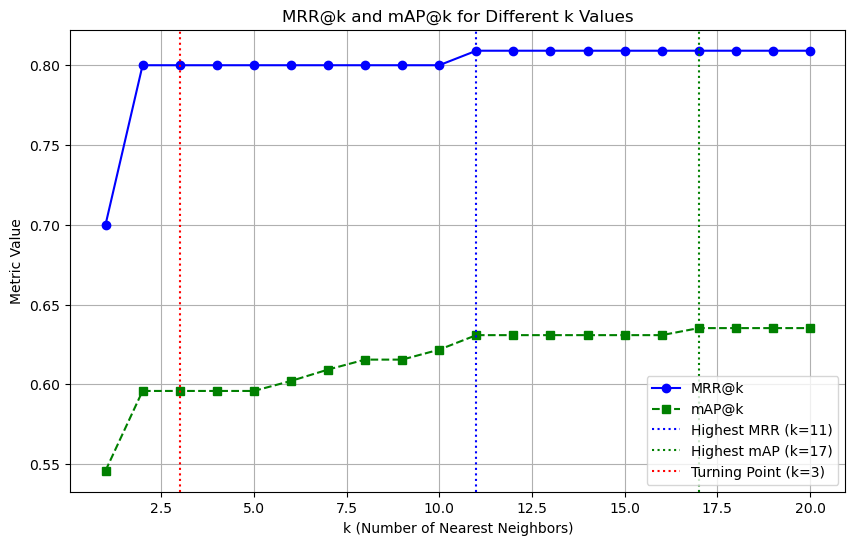

In [17]:
# Choose optimal K value based on MRR and mAP
import matplotlib.pyplot as plt

# Get MRR and mAP values for HNSW Index and cosine distance metric
MRR_k_cosine, mAP_k_cosine = MRR_k_all['FaissHNSW_cosine_index.pkl'], mAP_k_all['FaissHNSW_cosine_index.pkl']

# Get k values and MRR, mAP values
k_values = list(MRR_k_cosine.keys())
mrr_values = list(MRR_k_cosine.values())
map_values = list(mAP_k_cosine.values())


# Plot the results with K
plt.figure(figsize=(10, 6))
plt.plot(k_values, mrr_values, marker='o', linestyle='-', color='blue', label="MRR@k")
plt.plot(k_values, map_values, marker='s', linestyle='--', color='green', label="mAP@k")

# Plot the best k for MRR and mAP (highest values)
highest_mrr_k = k_values[np.argmax(mrr_values)]
highest_map_k = k_values[np.argmax(map_values)]

plt.axvline(x=highest_mrr_k, color='blue', linestyle='dotted', label=f"Highest MRR (k={highest_mrr_k})")
plt.axvline(x=highest_map_k, color='green', linestyle='dotted', label=f"Highest mAP (k={highest_map_k})")

# Plot the optimal k for MRR and mAP (turning point where MRR and mAP increases and then plateaus)
plt.axvline(x=3, color='red', linestyle='dotted', label=f"Turning Point (k=3)")

# Labels and legend
plt.xlabel('k (Number of Nearest Neighbors)')
plt.ylabel('Metric Value')
plt.title('MRR@k and mAP@k for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

#### **Impact of k on Performance**
- Both MRR@k and mAP@k increase up to k=3 and then plateau.
- MRR@k reaches its highest value when k=11
- mAP@k reaches its highest value when k=19

#### **Insights and Recommendations**
* Once the system released, it will handle millions of known personnel, instead of thousands in this case. Given the increased computation load, k can be set as 3 as default, to keep a good balance between performance and computational efficiency. However, if better accuracy are expected, k can be further increased. 
